<a href="https://colab.research.google.com/github/zideric/colab/blob/main/Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic, Mini batch e Full batch Gradient Descent

vediamo le tre varianti dell'algoritmo di ottimizzazione

* **Full Batch:** utilizza tutti gli esempi per correggere i coefficienti
* **Stochasti:** un solo esempio per volta per correggere i coefficienti
* **Mini Batch:** utilizza un determinato numero di esempio per volta per correggere i coefficienti

utilizziamo il [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), contiene capi di abbigliamento corrrettamente classificati, creato da Zalando

Importiamo i moduli

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from time import time

#definisco la funzione di profession AI per poter riprodurre i risultati in questo notebook

def set_seed(seed):
    from os import environ
    environ["PYTHONHASHSEED"] = '0'
    environ["CUDA_VISIBLE_DEVICES"]='-1'
    environ["TF_CUDNN_USE_AUTOTUNE"] ='0'

    from numpy.random import seed as np_seed
    np_seed(seed)
    import random
    random.seed(seed)
    from tensorflow import set_random_seed
    set_random_seed(seed)

## Preparazione dei dati

carichiamo il dataset direttamente da Keras.

In [2]:
from keras.datasets import fashion_mnist

labels = ["T-shirt/top","Pantalone","Pullover","Vestito","Cappotto","Sandalo","Maglietta","Sneaker","Borsa","Stivaletto"]

(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

print("Numero di proprieta: " + str(X_train.shape[1]))
print("Esempi di training: " + str(X_train.shape[0]))
print("Esempi di test: " + str(X_test.shape[0]))



4423680/4422102 [==============================] - 0s 0us/step
Numero di proprieta: 28
Esempi di training: 60000
Esempi di test: 10000


l'immagine è rappresentata da una matrice di 28*28 pixel
visualizziamone una

L'immagine raffigura un/o T-shirt/top


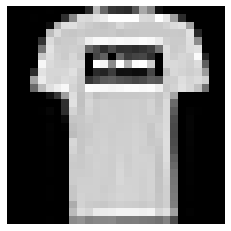

In [3]:
plt.axis("off") 
plt.imshow(X_train[1],cmap="gray")
print("L'immagine raffigura un/o %s" % labels[y_train[1]])


visto che ogni singolo elemmento (osservazione) è una matrice 28*28 dobbiamo convertire questa matrice in un singolo vettore da dare in input al modello. Usiamo reshape (al contrario del solito per visualizzare immagine)

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)

X_train.shape

(60000, 784)

standardizziamo i valori, anche in questo caso ci basta dividere ogni valore per 255 visto che 255 è il valore massimo e 0 il valore minimo

In [6]:
X_train = X_train/255
X_test = X_test/255

Gli array con i target contengono un valore numerico che va da 0 a 9, questo numero rappresenta la categoria di appartenenza del prodotto.
per poter eseguire la classificazione multiclasse dobbiamo crare 10 variabili dumm per ogni osservaizone, una per ogni classe, quella con il valore 1 sarà la classe identificata dal modelllo (creiamo un array di 10 elementi per ogni target)

In [7]:
from keras.utils import to_categorical

num_classes = 10

y_train_dummy = to_categorical(y_train, num_classes)
y_test_dumyy = to_categorical(y_test, num_classes)

## Full batch

creiamo il modello, usiamo la stessa architettura del notebook precedente

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from time import time

#definisco la funzione di profession AI per poter riprodurre i risultati in questo notebook

def set_seed(seed):
    from os import environ
    environ["PYTHONHASHSEED"] = '0'
    environ["CUDA_VISIBLE_DEVICES"]='-1'
    environ["TF_CUDNN_USE_AUTOTUNE"] ='0'

    from numpy.random import seed as np_seed
    np_seed(seed)
    import random
    random.seed(seed)
    from tensorflow import set_random_seed
    set_random_seed(seed)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from time import time

#definisco la funzione di profession AI per poter riprodurre i risultati in questo notebook

def set_seed(seed):
    from os import environ
    environ["PYTHONHASHSEED"] = '0'
    environ["CUDA_VISIBLE_DEVICES"]='-1'
    environ["TF_CUDNN_USE_AUTOTUNE"] ='0'

    from numpy.random import seed as np_seed
    np_seed(seed)
    import random
    random.seed(seed)
    from tensorflow import set_random_seed
    set_random_seed(seed)

In [10]:
#set_seed(0)  #peer riprodurre i risultati come il corso
import tensorflow
tensorflow.random.set_seed(0
                           )


model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) #neurone di optput mettiamo softmax


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


sono oltre mezzo milione di parametri. Utilizziamo il metodo compile per preparare il modello per l'addestramento. 
Come ottimizzatore usiamo sempre lo stochastic (sgd, vediamo perche bisogna specificare sempre questo anche se vogliamo full batch)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

Adesso, per utilizzare il full batch gradient descent, non dobbiamo far altro che specificare all'interno del metodo fit che la dimensione di un batch deve essere pari al numero di osservazioni nel set di addestramento, in tal modo l'algoritmo di ottimizzazione utilizzerà un unico batch con tutte le osservazioni ad ogni iterazione del gradient descent.
Per poter costruire un grafico della funzione di costo ad ogni epoca dobbiamo tener traccia di questi valori, per farlo dobbiamo definire un callback.

In [13]:
from keras.callbacks import History

history = History()

start_at = time()
model.fit(X_train, y_train_dummy, epochs=10, batch_size=X_train.shape[0],callbacks=[history])
exec_time= time()-start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.4030 - accuracy: 0.0945
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 2.3737 - accuracy: 0.0919
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 2.3477 - accuracy: 0.0898
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 2.3245 - accuracy: 0.0915
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 2.3036 - accuracy: 0.0982
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 2.2844 - accuracy: 0.1115
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 2.2665 - accuracy: 0.1303
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 2.2497 - accuracy: 0.1525
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 2.2337 - accuracy: 0.1796
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 2.2183 - accuracy: 0.2095
Tempo di addestramento: 0 minuti e 27 secondi


I risultati del modello sono piuttosto scarsi, perché le 100 epoche non erano sufficenti a portare alla convergenza, infatti con ulteriori epoche il modello avrebbe continuato a migliorare.
Utilizziamo i valori della funzione di costo raccolti per visualizzare la sua variazione a ogni epoche su di un grafico.

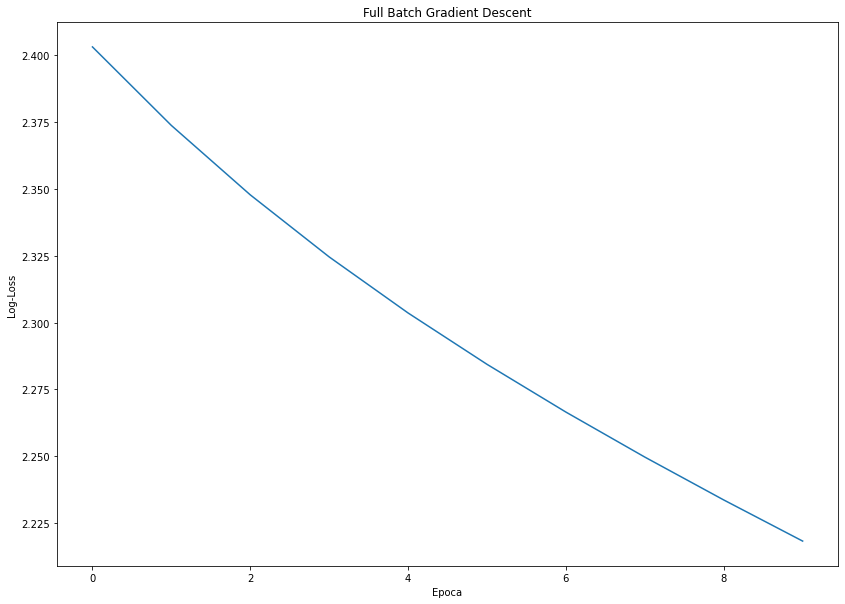

In [14]:
plt.figure(figsize=(14,10))
plt.title("Full Batch Gradient Descent")
plt.xlabel("Epoca")
plt.ylabel("Log-Loss")
plt.plot(history.history['loss'])

come si puo osservare, l'errore del modello si è ridotto in maniera pulita senza oscillazioni

## Stochastic Gradient Descent

questo è l'estremo opposto, iniziamo ricostruendo il modello

In [15]:
tensorflow.random.set_seed(0
                          ) #per poter riprodurrer i risultati

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

abbiamo dovuto ricreare il modello altrimenti chiamando il metodo fit l'addestramento sarebbe ripartito da dove si era  fermato all'esecuzione precedente (quindi fino a dove aveva iniziato ad imparare) continuando a ottimizzare i coefficienti che aveva già trovato

compiliamo il modello

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

Adesso, per utilizzare lo Stochastic Gradient Descent, impostiamo come dimensione del singolo batch 1, in modo tale da far utilizzare all'algoritmo di ottimizzazione un esempio per volta. Facendo questo il gradient descent ad ogni epoca viene eseguito un numero di volte pari al numero di esempi nel set di addestramento (nel nostro caso 60.000), ne segue che il completamento di un'epoca richiederà molto più tempo rispetto al full batch. Per questo motivo impostiamo il numero di epoche a 5.

In [17]:
start_at = time()
model.fit(X_train, y_train_dummy, epochs=5, batch_size=1)
exec_time = time()- start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/5
60000/60000 [==============================] - 122s 2ms/step - loss: 0.6336 - accuracy: 0.7683
Epoch 2/5
29809/60000 [=============>................] - ETA: 1:01 - loss: 0.3985 - accuracy: 0.8520

KeyboardInterrupt: ignored

Nel mio caso, l'esecuzione di 5 epoche di stochastic gradient descent ha richiesto 4 volte il tempo del full batch, ma l'addestramento si è concluso con un risultato decisamente migliore.

## Mini Batch Gradient Descent

questa è la versione intermedia e anche quella più consigliata da utilizzare

ricreiamo e ricompiliamo il modello

In [22]:
tensorflow.random.set_seed(0
                          ) #per poter riprodurrer i risultati

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

all'interno del metodo fit specifichiamo la dimensione di ogni batch, i valori consigliati sono quelli in potenza di 2 quindi 32, 64, 128, 256 e 512

optiamo per 512 (farò poi delle prove con i diversi valori)

In [23]:
history = History()
batch=128

"""
128 8 minuti e 17 secondi - loss: 0.1460 - accuracy: 0.9498
256 6 minuti e 38 secondi - loss: 0.2308 - accuracy: 0.9187
512 5 minuti e 53 secondi - loss: 0.3057 - accuracy: 0.8917
"""

start_at= time()
model.fit(X_train, y_train_dummy, epochs=100, batch_size=batch, callbacks=[history])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/100
469/469 [==============================] - 5s 10ms/step - loss: 1.4487 - accuracy: 0.5730
Epoch 2/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6258 - accuracy: 0.7942
Epoch 3/100
469/469 [==============================] - 5s 10ms/step - loss: 0.5297 - accuracy: 0.8223
Epoch 4/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4909 - accuracy: 0.8308
Epoch 5/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4642 - accuracy: 0.8380
Epoch 6/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4457 - accuracy: 0.8453
Epoch 7/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4265 - accuracy: 0.8526
Epoch 8/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4168 - accuracy: 0.8545
Epoch 9/100
469/469 [==============================] - 5s 10ms/step - loss: 0.4093 - accuracy: 0.8561
Epoch 10/100
469/469 [==============================] - 5s 10ms/step - loss: 0.392

il mini batch con size di 512 ha richiesto poco piu tempo del full ma ha portato a un risultato estremamente migliore

visualizziamo sul grafico la variazione dell'errore ad ogni epoca


In [ ]:
plt.figure(figsize=(14,10))
plt.title("Mini Batch gradient Descent - Batch Size = 512")
plt.xlabel("Epoca")
plt.ylabel("Log-Loss")
plt.plot(history.history['loss'])

l'errore si è ridotto molto in fretta durante le prime 10 epoche, dopodichè ha continuato a migliorare più lentamento oscillando leggermente.

In [ ]:
type(history.history)